In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
import os
from scipy.stats import mode
#from iri2016 import timeprofile, timeprofile2

In [2]:
current_month = 'Agosto-2020'
directory = 'Data-%s/' % current_month
plot_format = 'png'
filename1 ='jul20200803_150km.001.hdf5' 
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15


In [3]:
file_hf5 = directory + filename1
hf = h5py.File(file_hf5, 'r')

with h5py.File(file_hf5, 'r') as f:
    g = f.visit(print)

Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/1D Parameters/Data Parameters
Data/Array Layout/1D Parameters/gdlatr
Data/Array Layout/1D Parameters/gdlonr
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dvipe1
Data/Array Layout/2D Parameters/dvipn1
Data/Array Layout/2D Parameters/gdalt
Data/Array Layout/2D Parameters/snl
Data/Array Layout/2D Parameters/vipe1
Data/Array Layout/2D Parameters/vipn1
Data/Array Layout/Layout Description
Data/Array Layout/range
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters


In [36]:
def makeBinaryPlot(directory, filename1): 
    plot_format = 'png'
    PlotFlag = True
    file_hf5 = directory + os.sep + filename1
    hf = h5py.File(file_hf5, 'r')
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    rango2 = hf['Data/Array Layout/2D Parameters/gdalt']
    rango2D = hf['Data/Array Layout/']['range']
    snl =  np.array(hf['Data/Table Layout/']['snl'], dtype=float)
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    timestamps = hf['Data/Array Layout/']['timestamps']
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    ######################################################################
    index = pd.DatetimeIndex(date_list) - timedelta(hours=5)
    datetime_objects = [datetime.datetime.fromtimestamp(t2) for t2 in timestamps]
    str_start = '%d/%02d/%02d %02d:%02d:%02d' % (index[0].year, index[0].month, index[0].day, index[0].hour, 0,7)
    str_end = '%d/%02d/%02d %02d:%02d:%02d' % (index[-1].year, index[-1].month,index[0].day, 18, 0,0)
    ind_size = 500
    index_prime = pd.date_range(start=str_start, end=str_end, periods=ind_size)
    datetime_objects_prime = [indp.to_pydatetime() for indp in index_prime]
    ran_max = 180 # (km)max(rango)
    ran_min = 120#min(rango)
    MinRange, MaxRange = ran_min, ran_max
    range_diff = np.diff(rango)
    delta_range = range_diff[0]
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    DataMatrix_new = np.ones((DataMatrixRows+1, len(datetime_objects_prime)))*np.nan
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    range_array_old = np.linspace(np.min(rango), np.max(rango), int((np.max(rango)-np.min(rango))/delta_range)+1)
    RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
    string_date = index[0].strftime('%B %d, %Y, %r')
    mes = string_date.split()[0]
    month_prime = index[0].month

    if mes == 'June':
        mes ='Junio'
    if mes == 'July':
        mes = 'Julio'
    if mes == 'August':
        mes = 'Agosto'
    dia = index[0].day
    anio = index[0].year
    dir_plots = '.'#'Processed-Plots-%s-%d' % (mes, anio)
    
    delta_t = mode(np.diff(datetime_objects_prime)[0].seconds)[0][0]
    datetime_objects = np.array(datetime_objects)
#RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
#RowInMatrix_t = np.array((datetime_objects-datetime_objects_prime[0])/delta_t, dtype=int)
    t_ind = [int((dt-datetime_objects_prime[0]).seconds/delta_t) for dt in datetime_objects]
    fil, col = np.array(snl2).T.shape
    for i in range(fil) :
        row = RowInMatrix[i]
        for j in range(col):
    # Putting snr in corresponding matrix element
            #print(row,j,t_ind[j])
            DataMatrix_new[row,t_ind[j]] = np.array(snl2).T[i,j]#snl[k]
        
    #if row<PastRow:
    #    col += 1
    #PastRow = row
    data_new = DataMatrix_new[::-1]
    print(np.array(snl2).T.shape, DataMatrix_new.shape)
    print(delta_t, delta_range)
    #data_new[~np.isnan(data_new)] = 1
    #data_new[np.isnan(data_new)] = 0   
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.rcParams['xtick.labelsize']=16
        
        plt.style.use('dark_background')
        #x_min = mdates.date2num(np.min(index))
        #x_max = mdates.date2num(np.max(index))
        #extent=[x_min, x_max,ran_min,ran_max]
        #im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        #im2 = plt.imshow(data_new, cmap='jet',aspect='auto',interpolation='nearest',origin="lower")
        clrs = ax.pcolormesh(mdates.date2num(datetime_objects_prime),range_array,data_new)
        
        #ax.xaxis_date()
        #date_format = mdates.DateFormatter('%H:%M')
        #ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlabel("Hora Local (h)", fontsize=17)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ocurrencia: Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=20)
        # This simply sets the x-axis data to diagonal so it fits better.
        #fig.autofmt_xdate()
        #cb2 = fig.colorbar(im2)
        #cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label('SNR (dB)')
        plt.savefig(r'%s/binary-matrix-ecos-150km-SNR-%d-%02d-%02d.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
########################################################3
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=16
        
        #plt.style.use('dark_background')
        #x_min = mdates.date2num(np.min(index))
        #x_max = mdates.date2num(np.max(index))
        #extent=[x_min, x_max,ran_min,ran_max]
        #im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        #im2 = plt.imshow(data_new, cmap='jet',aspect='auto',interpolation='nearest',origin="lower")
        clrs = ax.pcolormesh(mdates.date2num(datetime_objects),range_array_old,np.array(snl2).T)
        
        #ax.xaxis_date()
        #date_format = mdates.DateFormatter('%H:%M')
        #ax.xaxis.set_major_formatter(date_format)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlabel("Hora Local (h)", fontsize=17)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ocurrencia: Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=20)
        # This simply sets the x-axis data to diagonal so it fits better.
        #fig.autofmt_xdate()
        #cb2 = fig.colorbar(im2)
        #cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)
        cb.set_label('SNR (dB)')
        #plt.savefig(r'%s/binary-matrix-ecos-150km-SNR-%d-%02d-%02d.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
        
    
    return data_new, datetime_objects_prime, range_array, np.array(snl2).T, t_ind, RowInMatrix

/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Discarding nonzero nanoseconds in conversion


(32, 402) (41, 500)
79 1.5


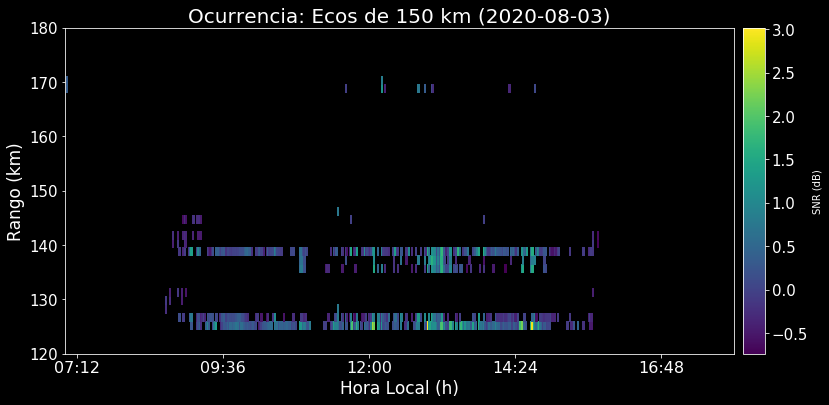

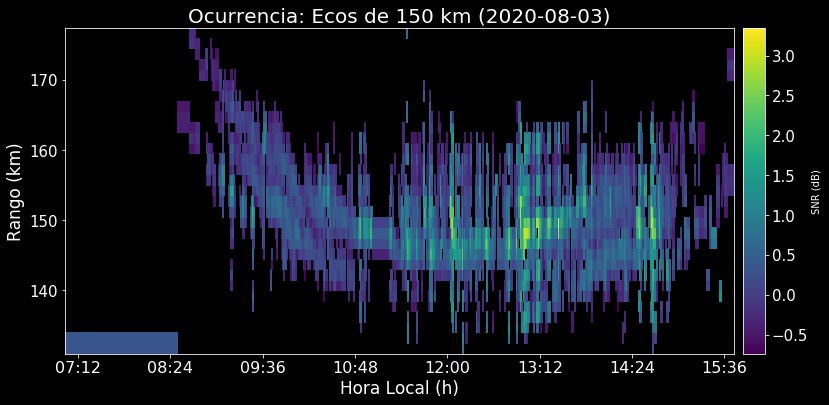

(32, 402) (41, 500)
[1, 68, 75, 78, 78, 80, 84, 85, 85, 87, 88, 88, 89, 90, 92, 93, 93, 94, 95, 95, 96, 98, 98, 99, 100, 100, 101, 102, 103, 103, 104, 105, 105, 106, 107, 107, 108, 109, 110, 110, 111, 112, 112, 113, 114, 115, 115, 116, 117, 117, 118, 119, 120, 121, 122, 122, 123, 124, 125, 125, 126, 127, 127, 128, 129, 130, 130, 131, 132, 132, 133, 134, 135, 135, 136, 137, 137, 138, 139, 140, 140, 141, 142, 142, 143, 144, 145, 145, 146, 147, 147, 148, 149, 150, 150, 151, 152, 152, 153, 154, 155, 155, 156, 157, 157, 158, 159, 160, 160, 161, 162, 162, 163, 164, 165, 165, 166, 167, 168, 169, 170, 170, 171, 172, 172, 173, 174, 175, 175, 176, 177, 177, 178, 179, 180, 180, 181, 182, 183, 193, 194, 194, 195, 196, 197, 197, 198, 199, 199, 200, 201, 202, 202, 203, 204, 204, 205, 206, 207, 209, 210, 210, 211, 212, 213, 213, 214, 215, 215, 216, 217, 218, 218, 219, 220, 220, 221, 222, 223, 223, 224, 225, 225, 226, 227, 228, 228, 229, 230, 230, 231, 232, 232, 233, 234, 235, 235, 236, 237, 237, 238,

In [41]:
#%matplotlib widget

#%matplotlib inline

binary_matrix, datetime_objects, range_array, snl2, t_ind, RowInMatrix  = makeBinaryPlot(directory, filename1)
#fig3, ax = plt.subplots(figsize=(12, 6))
#fig3.canvas.toolbar_visible = False
#fig3.canvas.header_visible = False
#fig3.canvas.resizable = True
#plt.imshow(binary_matrix,aspect='auto',interpolation='nearest',origin="lower")
#im3 = plt.imshow(snl2,aspect='auto',cmap='jet',interpolation='nearest',origin="lower")
#cb3 = fig3.colorbar(im3)
#cb3.set_label(r'$log_{10}SNR$', fontsize=17)
print(snl2.shape, binary_matrix.shape)
print(t_ind)
print(RowInMatrix)
print((datetime_objects[10]-datetime_objects[9]).seconds)
        #im2 = plt.imshow(data_new, cmap='jet',aspect='auto',interpolation='nearest',origin="lower")

Data-Agosto-2020/jul20200815_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


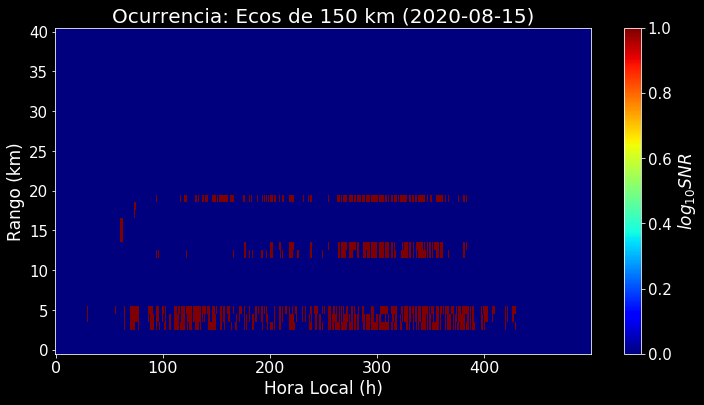

(41, 500)
Data-Agosto-2020/jul20200821_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


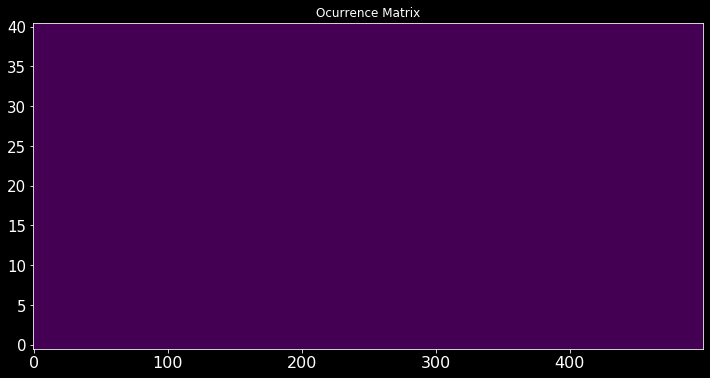

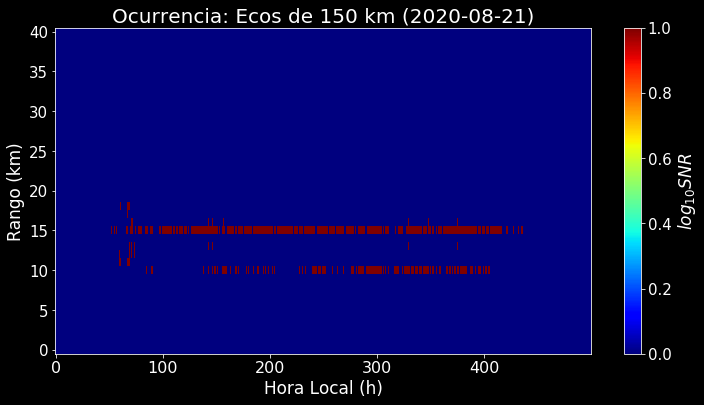

(41, 500)
Data-Agosto-2020/jul20200801_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


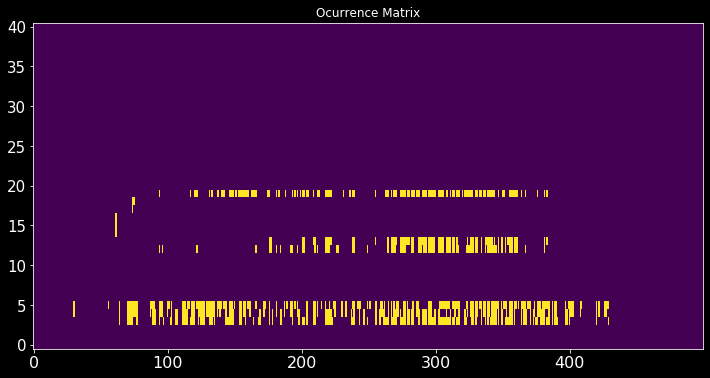

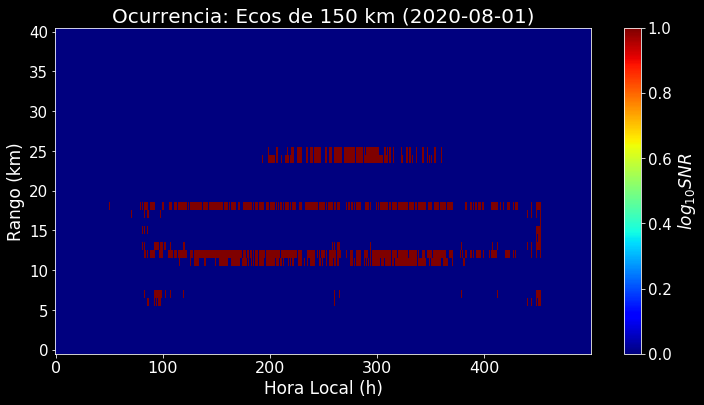

(41, 500)
Data-Agosto-2020/jul20200805_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


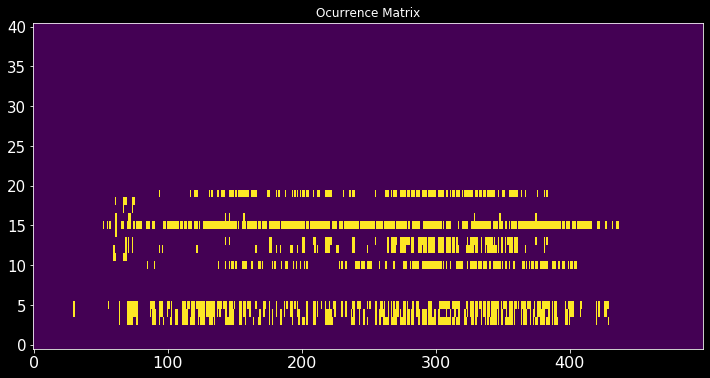

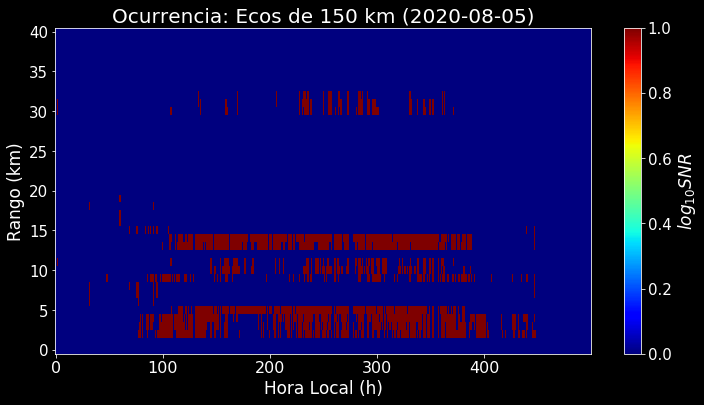

(41, 500)
Data-Agosto-2020/jul20200810_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


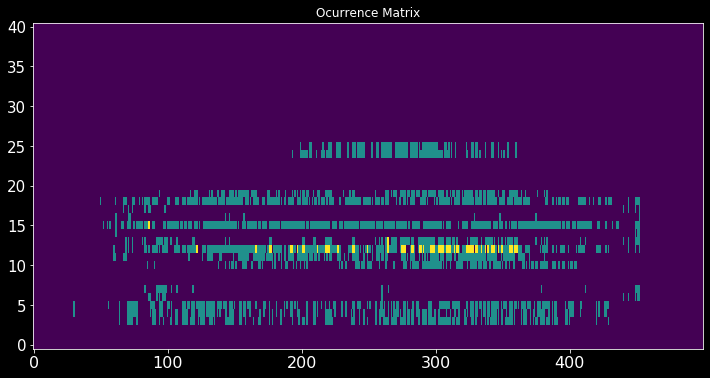

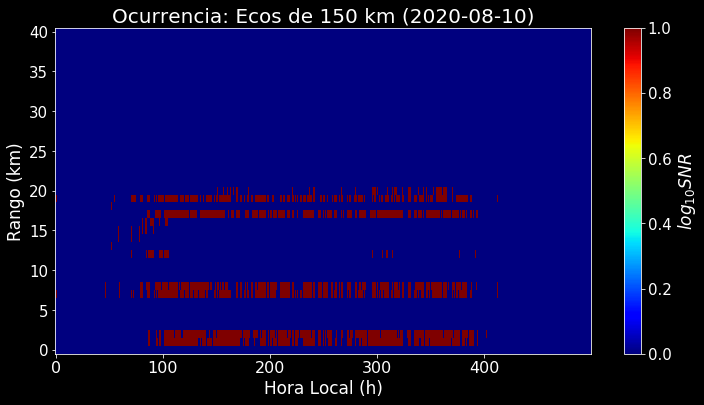

(41, 500)
Data-Agosto-2020/jul20200806_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


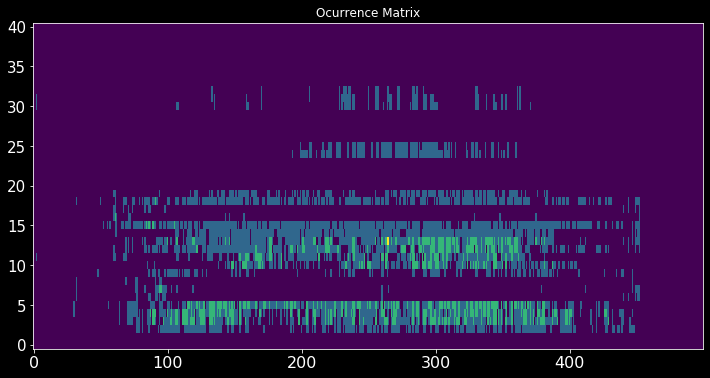

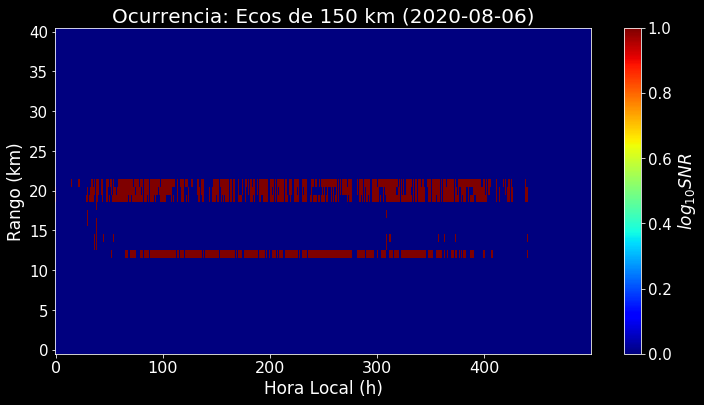

(41, 500)
Data-Agosto-2020/jul20200808_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


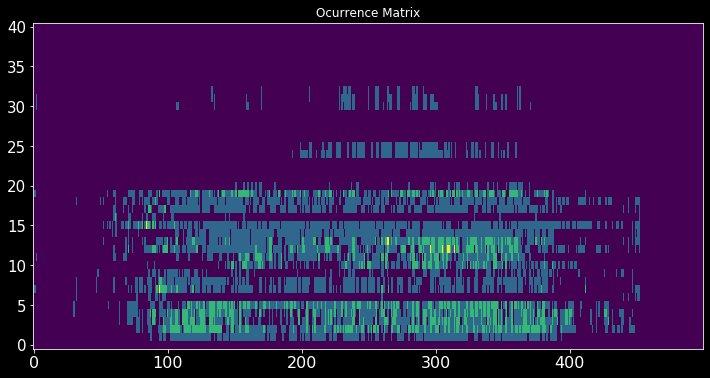

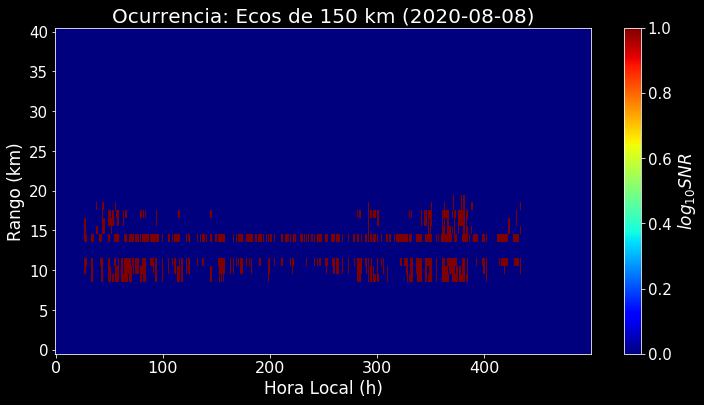

(41, 500)
Data-Agosto-2020/jul20200804_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


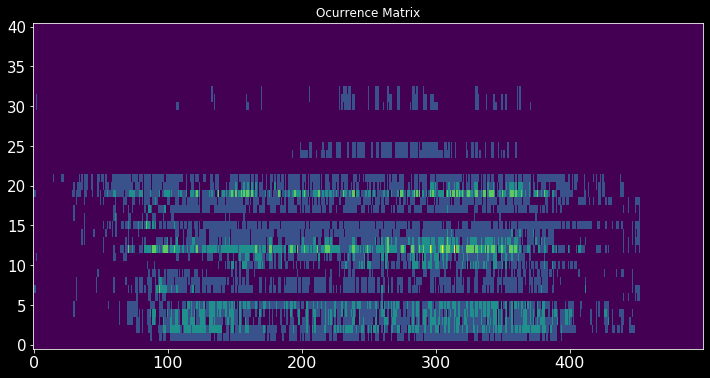

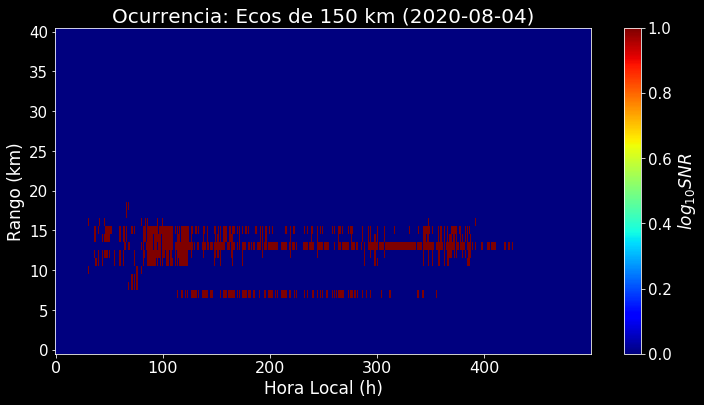

(41, 500)
Data-Agosto-2020/jul20200822_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


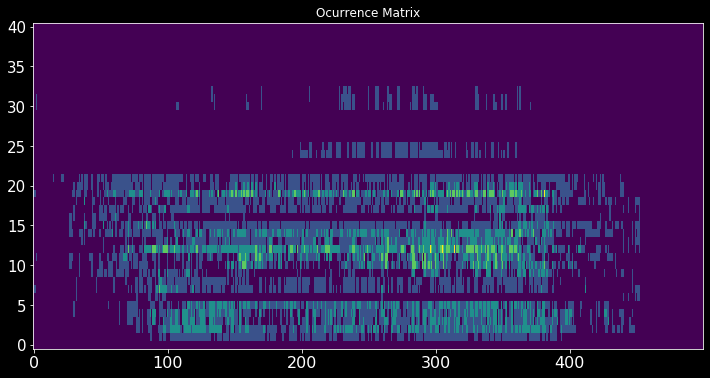

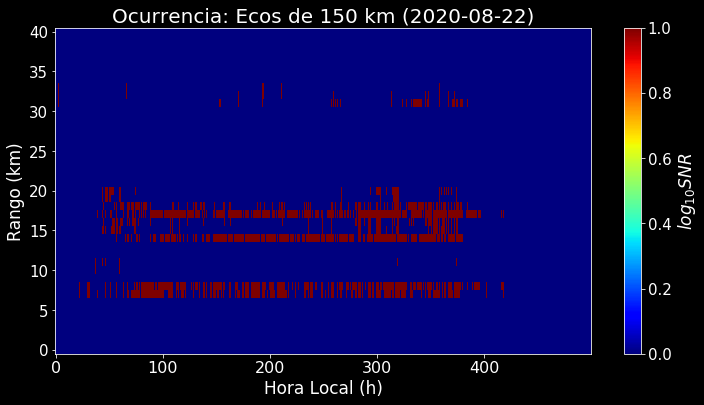

(41, 500)
Data-Agosto-2020/jul20200809_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


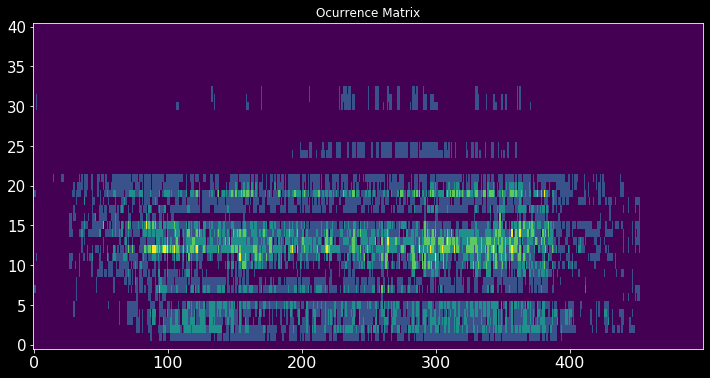

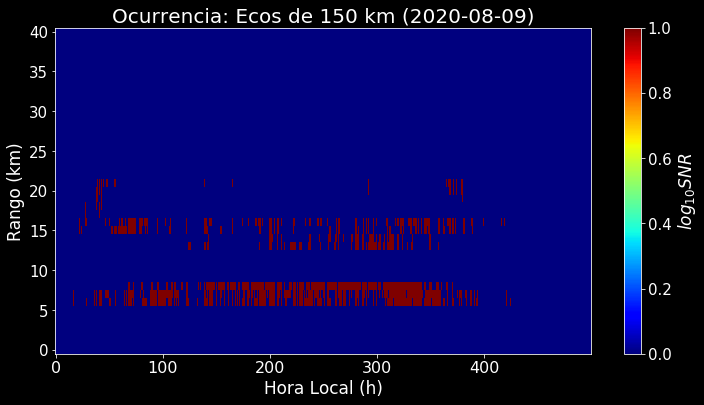

(41, 500)
Data-Agosto-2020/jul20200802_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


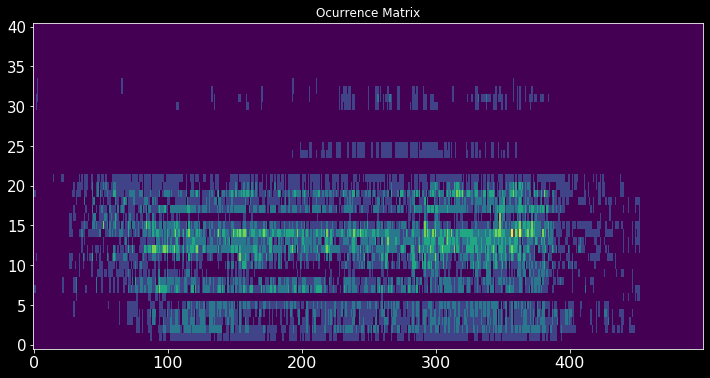

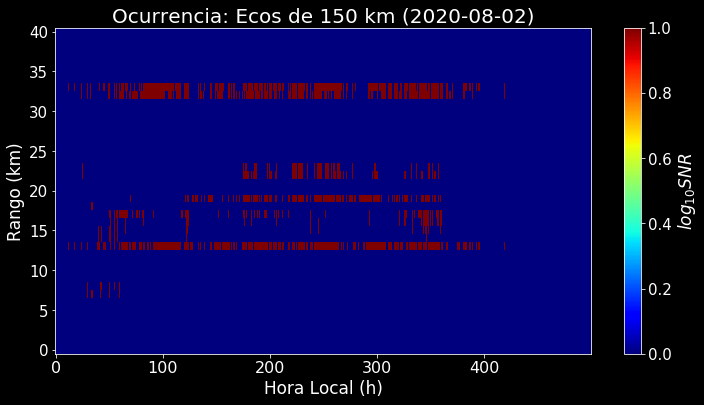

(41, 500)
Data-Agosto-2020/jul20200803_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


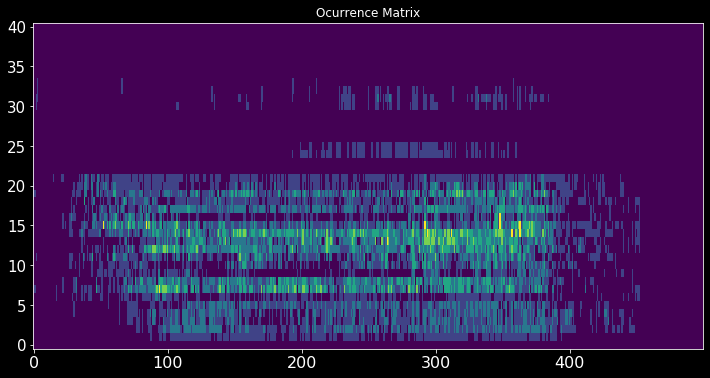

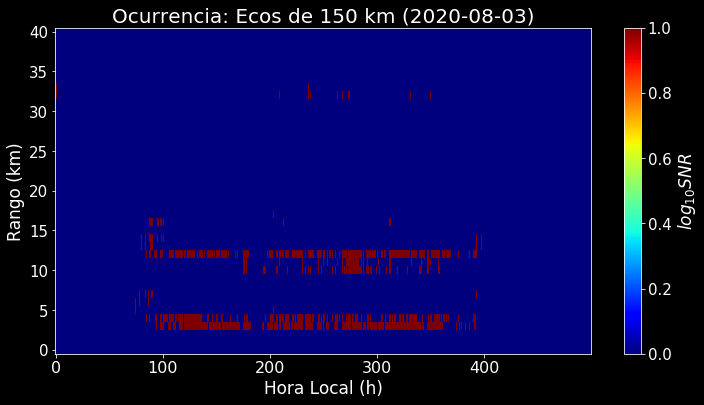

(41, 500)
Data-Agosto-2020/jul20200816_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


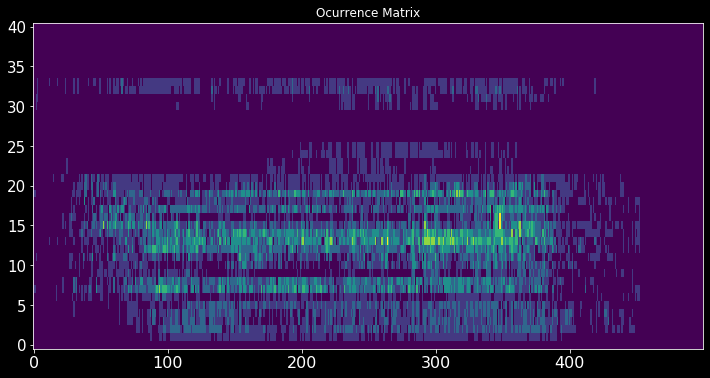

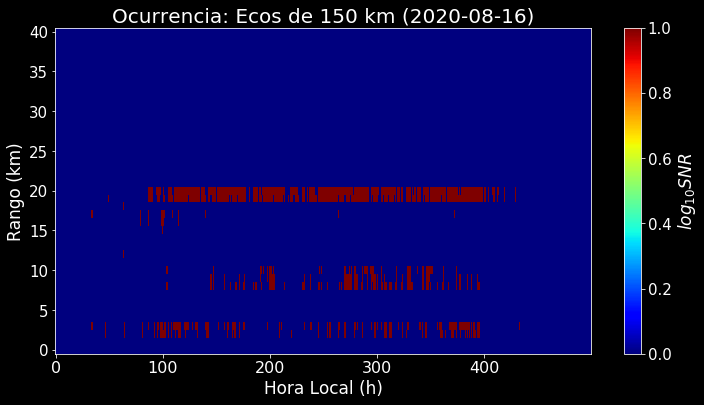

(41, 500)
Data-Agosto-2020/jul20200823_150km.001.hdf5


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Discarding nonzero nanoseconds in conversion


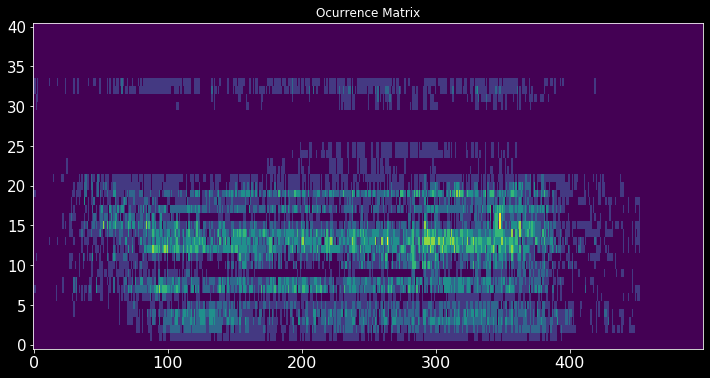

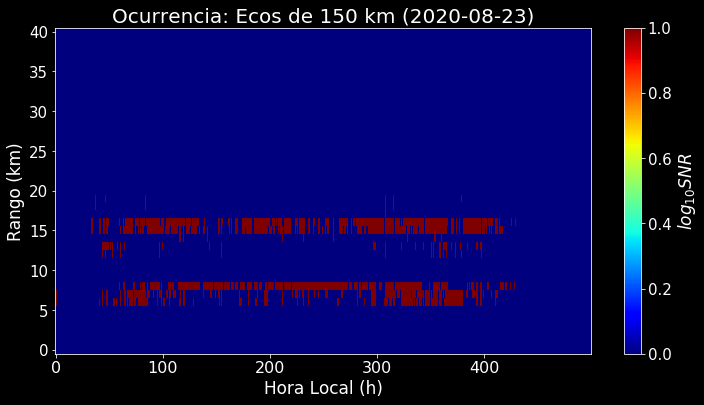

(41, 500)


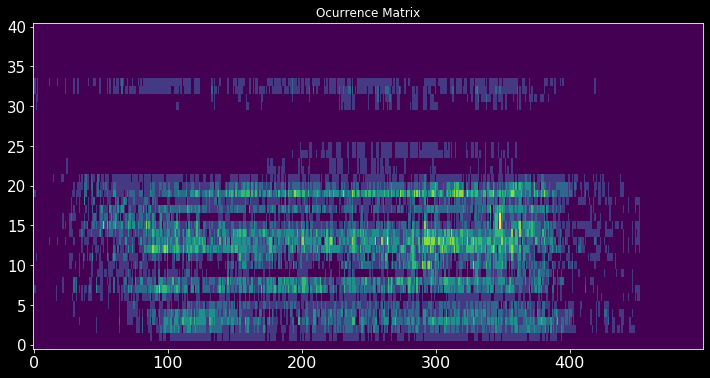

In [44]:
#'''
PlotFlag = True
plot_format= 'png'

occurrence_matrix = np.zeros(binary_matrix.shape, dtype=float)
num_files = 0
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        print(os.path.join(directory, filename))
        #data2 ,snl2, snl2D, index2, index_02 ,rango2, range_array2 = BuildSNRMatrix2(directory, filename1, PlotFlag, plot_format)
        binary_matrix, datetime_objects, range_array = makeBinaryPlot(directory, filename)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.imshow(occurrence_matrix,aspect='auto',interpolation='nearest',origin="lower")
        plt.title('Ocurrence Matrix')
        print(binary_matrix.shape)
        occurrence_matrix +=  binary_matrix
        num_files = num_files + 1

occurrence_matrix/=float(num_files)
#'''

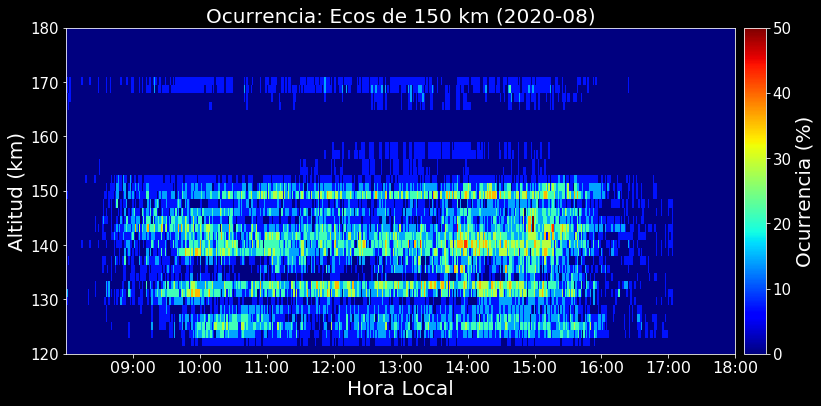

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams['xtick.labelsize']=16        
plt.style.use('dark_background')
'''
x_min = mdates.date2num(np.min(datetime_objects))
x_max = mdates.date2num(np.max(datetime_objects))
ran_min, ran_max = 120, 180
extent=[x_min, x_max,ran_min,ran_max]
im3 = plt.imshow(100*occurrence_matrix/num_files,aspect='auto',interpolation='nearest',origin="lower")
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=17)
ax.set_ylabel("Rango (km)", fontsize=17)
fig_title = r'Ecos de 150 km: Ocurrencia %d-%02d' % (2020, 8) 
plt.title(fig_title, fontsize=20)
# This simply sets the x-axis data to diagonal so it fits better.

fig.autofmt_xdate()
cb3 = fig.colorbar(im3)
cb3.set_label(r'Ocurrencia (%)', fontsize=17)
#plt.clim(0,0.1)
'''
       
#'''  
plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects,range_array,100*occurrence_matrix, cmap='jet')#,vmin=0,vmax=2e11)
#    clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,data[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ocurrencia: Ecos de 150 km (%d-%02d)' % (datetime_objects[0].year, datetime_objects[0].month) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=20)
ax.set_ylabel('Altitud (km)', fontsize=20)
ax.set_title(fig_title, fontsize=20)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ocurrencia (%)', fontsize=20)
#plt.savefig('new-plots-vertical-drift-%d-%02d-%02d.png' % (day_index[0].year, day_index[0].month, day_index.day[0]))
    #if indf == 0:
    #    inf
    #print("índices iniciales y finales:", ind0, indf)
    #print(datetime_objects[-1])
    #print(datetime_objects[ind0])
#'''
plt.savefig('ocurrencia-ecos-150km-agosto-2020.png')

In [ ]:
file_hf5 = directory + os.sep + filename1
hf = h5py.File(file_hf5, 'r')
days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
rango = hf['Data/Table Layout/']['gdalt']
rango2 = hf['Data/Array Layout/2D Parameters/gdalt']
rango2D = hf['Data/Array Layout/']['range']
snl =  np.array(hf['Data/Table Layout/']['snl'], dtype=float)
snl2 = hf['Data/Array Layout/2D Parameters/snl']
time2 = hf['Data/Array Layout/']['timestamps'] #It is in LT!
timestamps = hf['Data/Array Layout/']['timestamps']
    #######################################################
    #converted_value = getattr(value, "tolist", lambda: value)()
    #converted_value = getattr(value, "tolist", lambda: value)()
days = getattr(days, "tolist", lambda: days)()
year = getattr(year, "tolist", lambda: year)()
month = getattr(month, "tolist", lambda: month)()
hour = getattr(hour, "tolist", lambda: hour)()
minutes = getattr(minutes, "tolist", lambda: minutes)()
seconds = getattr(seconds, "tolist", lambda: seconds)()
rango = getattr(rango, "tolist", lambda: rango)()
time_vector = []
date_list = [] # list for datetime objects
datetimeFormat = '%Y-%m-%d %H:%M:%S'
for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
    date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
    date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
    time_vector.append(date_string)
    date_list.append(date)
    ######################################################################
index_0 = pd.DatetimeIndex(date_list) - timedelta(hours=5)
time2_object = [datetime.datetime.fromtimestamp(t2) for t2 in time2]
index = pd.to_datetime(time2_object)
ran_max = 180 # (km)max(rango)
ran_min = 120#min(rango)
range_diff = np.diff(rango)
delta_range = range_diff[0] # (km) valor constante para todo el arreglo
MinRange, MaxRange = ran_min, ran_max#np.max(rango)
DataMatrixRows = int((MaxRange-MinRange)/delta_range)
DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
#DataMatrix = np.ones((DataMatrixRows+1, range_array.size))*np.nan
RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #RangeMatrix = np.ones((DataMatrixRows+1, range_array.size))*np.nan
    ######################################################################3
str_start = '%d/%02d/%02d %02d:%02d:%02d' % (index[0].year, index[0].month, index[0].day, index[0].hour, 0,7)
str_end = '%d/%02d/%02d %02d:%02d:%02d' % (index[-1].year, index[-1].month,index[0].day, 18, 0,0)
    #index_prime = pd.date_range(start=str_start, end=str_end, freq='5min')
ind_size = 500
index_prime = pd.date_range(start=str_start, end=str_end, periods=ind_size)
print(type(index))
#######################################################
string_date = index[0].strftime('%B %d, %Y, %r')
#line.split()[0]
mes = string_date.split()[0]
month_prime = index[0].month

if mes == 'June':
    mes ='Junio'
if mes == 'July':
    mes = 'Julio'
if mes == 'August':
    mes = 'Agosto'
dia = index[0].day
anio = index[0].year
dir_plots = '.'#'Processed-Plots-%s-%d' % (mes, anio)

    #snr_prueba = snl.set_index(index_prime).groupby(pd.TimeGrouper('5 min')).mean()
    # Putting the data in the matrix
col = 0 #counter for current columns
PastRow = 0 #saving past row index
date_list=[] #Mon Dec  2 15:24:30 2019

for k in range(len(range_array)):
    row = RowInMatrix[k]
        
        # Putting snr in corresponding matrix element
    DataMatrix[row,col] = snl[k]
        
    if row<PastRow:
        col += 1
    PastRow = row
data = DataMatrix#[::-1]
    #rango2_plot = RangeMatrix 
    #rango2_plot= np.array(rango2).T
    #nbig = len(index_prime)
    #nsmall = len(range_array)
    #big = np.arange(nbig * nbig).reshape([nbig, nbig]) # 100x100
 
    #print(timestamps[0])
str_t0 = '2020-%02d-%02d 07:00:00' % (index_prime[0].month, index_prime[0].day)
str_tf = '2020-%02d-%02d 18:00:00' % (index_prime[0].month, index_prime[0].day)

t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
i = 0
ind0 = 0
indf = -1
datetime_objects = [] 
for ts in timestamps:
#datetime_objects.append(datetime.timestamp(ts))
    dt = datetime.datetime.fromtimestamp(ts)
    datetime_objects.append(dt)
    if (dt >= t0):
    #print('9 AM!', i)
        ind0=i
        continue
    if (dt >= tf):
        #print('5 PM!')
        indf=i
    i = i + 1
    
#datetime_objects_prime = []
#i = 0
#x = [datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in date_str]
datetime_objects_prime = [indp.to_pydatetime() for indp in index_prime]
'''
for ts in index_prime:
#datetime_objects.append(datetime.timestamp(ts))
    dt = datetime.datetime.fromtimestamp(ts)
    datetime_objects_prime.append(dt)
    if (dt >= t0):
    #print('9 AM!', i)
        ind0=i
        continue
    if (dt >= tf):
        #print('5 PM!')
        indf=i
    i = i + 1
'''
print(len(datetime_objects), len(datetime_objects_prime))
print(np.diff(datetime_objects)[0].seconds, np.diff(datetime_objects_prime)[0].seconds)
print(datetime_objects[0], datetime_objects[1])
print(datetime_objects_prime[0], datetime_objects_prime[1])
'''
for dp in datetime_objects_prime:
    print(dp)
for do in datetime_objects:
    print(do)
'''
delta_t_do = [dt.seconds for dt in np.diff(datetime_objects)]
plt.hist(delta_t_do, bins=100)
plt.xlim([0,200])

In [ ]:
#datetime_objects[0], index_prime[0]
delta_t = np.diff(datetime_objects_prime)[0].seconds
datetime_objects = np.array(datetime_objects)
#RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
#RowInMatrix_t = np.array((datetime_objects-datetime_objects_prime[0])/delta_t, dtype=int)
t_ind = [int((dt-datetime_objects_prime[0]).seconds/delta_t) for dt in datetime_objects]

In [ ]:
#print(t_ind)
range_diff = np.diff(rango)
delta_range = range_diff[0]
DataMatrixRows = int((MaxRange-MinRange)/delta_range)
DataMatrix_new = np.ones((DataMatrixRows+1, len(datetime_objects_prime)))*np.nan
range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
#print(range_array.shape)
#print(RowInMatrix.shape)

In [ ]:


#col = 0 #counter for current columns
PastRow = 0 #saving past row index
date_list=[] #Mon Dec  2 15:24:30 2019
print(np.array(snl2).shape, len(t_ind))
fil, col = np.array(snl2).T.shape
for i in range(fil) :
    row = RowInMatrix[i]
    for j in range(col):
    # Putting snr in corresponding matrix element
        print(row,j,t_ind[j])
        DataMatrix_new[row,t_ind[j]] = np.array(snl2).T[i,j]#snl[k]
        
    #if row<PastRow:
    #    col += 1
    #PastRow = row
data_new = DataMatrix_new#[::-1]


In [ ]:
print(np.array(snl2).shape, data_new.shape)
#plt.imshow(np.array(snl2).T,aspect='auto',interpolation='nearest',origin="lower")
plt.imshow(data_new,aspect='auto',interpolation='nearest',origin="lower")

In [ ]:
#'''
PlotFlag = True
plot_format= 'png'
#h_min = []
#h_max = []
#frames_avg = []
#frames_std = []
#num_stamps = []
#t_h_min = []
#t_h_max = []
occurence_matrix = np.zeros(data_new.shape)
num_files = 0
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        print(os.path.join(directory, filename))
        data2 ,snl2, snl2D, index2, index_02 ,rango2, range_array2 = BuildSNRMatrix2(directory, filename1, PlotFlag, plot_format)
        print(data2.shape, snl2D.shape,index2.shape, index_02.shape)
        data_bin = data2.copy()
        #data_bin[data_bin!=np.nan]=1.0
        data_bin[~np.isnan(data_bin)] = 1
        data_bin[np.isnan(data_bin)] = 0
        im = plt.imshow(data_bin,aspect='auto',interpolation='nearest',origin="lower")
        #data_bin[data_bin==np.nan]=0.0
        ocurrence_matrix = occurence_matrix + data_bin
        num_files = num_files + 1

occurrence_matrix = occurence_matrix/num_files
#'''

In [ ]:
def BuildSNRMatrix2(directory, filename, PlotFlag, plot_format):
    file_hf5 = directory + os.sep + filename
    hf = h5py.File(file_hf5, 'r')
    days = np.array(hf['Data/Table Layout/']['day'],dtype=int)
    year = np.array(hf['Data/Table Layout/']['year'],dtype=int)
    month = np.array(hf['Data/Table Layout/']['month'],dtype=int)
    hour = np.array(hf['Data/Table Layout/']['hour'],dtype=int)
    minutes = np.array( hf['Data/Table Layout/']['min'],dtype=int)
    seconds = np.array(hf['Data/Table Layout/']['sec'],dtype=int)
    rango = hf['Data/Table Layout/']['gdalt']
    rango2 = hf['Data/Array Layout/2D Parameters/gdalt']
    rango2D = hf['Data/Array Layout/']['range']
    snl =  np.array(hf['Data/Table Layout/']['snl'], dtype=float)
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    time2 = hf['Data/Array Layout/']['timestamps'] #It is in LT!
    timestamps = hf['Data/Array Layout/']['timestamps']
    #######################################################
    #converted_value = getattr(value, "tolist", lambda: value)()
    #converted_value = getattr(value, "tolist", lambda: value)()
    days = getattr(days, "tolist", lambda: days)()
    year = getattr(year, "tolist", lambda: year)()
    month = getattr(month, "tolist", lambda: month)()
    hour = getattr(hour, "tolist", lambda: hour)()
    minutes = getattr(minutes, "tolist", lambda: minutes)()
    seconds = getattr(seconds, "tolist", lambda: seconds)()
    rango = getattr(rango, "tolist", lambda: rango)()
    time_vector = []
    date_list = [] # list for datetime objects
    datetimeFormat = '%Y-%m-%d %H:%M:%S'
    for y, m, d,h, mmins, sec in zip(year,month,days,hour,minutes,seconds):
        date_string = '%d-%02d-%02d %02d:%02d:%02d' % (y,m,d,h,mmins,sec)
        date = datetime.datetime(y,m,d,h,mmins, sec)#, datetimeFormat)
        time_vector.append(date_string)
        date_list.append(date)
    ######################################################################
    index_0 = pd.DatetimeIndex(date_list) - timedelta(hours=5)
    time2_object = [datetime.datetime.fromtimestamp(t2) for t2 in time2]
    index = pd.to_datetime(time2_object)
    ran_max = 180 # (km)max(rango)
    ran_min = 120#min(rango)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] # (km) valor constante para todo el arreglo
    MinRange, MaxRange = ran_min, ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    #DataMatrix = np.ones((DataMatrixRows+1, range_array.size))*np.nan
    RowInMatrix = np.array((np.array(rango)-MinRange)/delta_range, dtype=int)
    #RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    #RangeMatrix = np.ones((DataMatrixRows+1, range_array.size))*np.nan
    ######################################################################3
    str_start = '%d/%02d/%02d %02d:%02d:%02d' % (index[0].year, index[0].month, index[0].day, index[0].hour, 0,7)
    str_end = '%d/%02d/%02d %02d:%02d:%02d' % (index[-1].year, index[-1].month,index[-1].day, 18, 0,0)
    #index_prime = pd.date_range(start=str_start, end=str_end, freq='5min')
    ind_size = 500
    index_prime = pd.date_range(start=str_start, end=str_end, periods=ind_size)
    print(type(index))
    #######################################################
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    mes = string_date.split()[0]
    month_prime = index[0].month
    if mes == 'June':
        mes ='Junio'
    if mes == 'July':
        mes = 'Julio'
    if mes == 'August':
        mes = 'Agosto'
    dia = index[0].day
    anio = index[0].year
    dir_plots = '.'#'Processed-Plots-%s-%d' % (mes, anio)

    #snr_prueba = snl.set_index(index_prime).groupby(pd.TimeGrouper('5 min')).mean()
    # Putting the data in the matrix
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    date_list=[] #Mon Dec  2 15:24:30 2019

    for k in range(len(range_array)):
        row = RowInMatrix[k]
        
        # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
    #rango2_plot = RangeMatrix 
    #rango2_plot= np.array(rango2).T
    #nbig = len(index_prime)
    #nsmall = len(range_array)
    #big = np.arange(nbig * nbig).reshape([nbig, nbig]) # 100x100
 
    #print(timestamps[0])
    str_t0 = '2020-%02d-%02d 07:00:00' % (index_prime[0].month, index_prime[0].day)
    str_tf = '2020-%02d-%02d 18:00:00' % (index_prime[0].month, index_prime[0].day)

    t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
    tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
    i = 0
    ind0 = 0
    indf = -1
    datetime_objects = [] 
    for ts in timestamps:
    #datetime_objects.append(datetime.timestamp(ts))
        dt = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(dt)
        if (dt >= t0):
        #print('9 AM!', i)
            ind0=i
            continue
        if (dt >= tf):
        #print('5 PM!')
            indf=i
        i = i + 1
    #fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
        #plt.style.use('dark_background')
        #x_min = mdates.date2num(np.min(index))
        #x_max = mdates.date2num(np.max(index))
        #extent=[x_min, x_max,ran_min,ran_max]
        #im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        cb2 = fig.colorbar(im2)
        cb2.set_label(r'$log_{10}SNR$', fontsize=17)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/binary-matrix-ecos-150km-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
        #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
    '''  
    plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
    clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,data[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
    fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Hora Local', fontsize=20)
    ax.set_ylabel('Altitud (km)', fontsize=20)
    ax.set_title(fig_title, fontsize=20)

    box=ax.get_position()
    cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
    cb=plt.colorbar(clrs,cax=cbarax)
    cb.set_label('Velocidad vertical (ms)', fontsize=20)
    plt.savefig('new-plots-vertical-drift-%d-%02d-%02d.png' % (day_index[0].year, day_index[0].month, day_index.day[0]))
    #if indf == 0:
    #    inf
    #print("índices iniciales y finales:", ind0, indf)
    #print(datetime_objects[-1])
    #print(datetime_objects[ind0])
    '''
    return  data ,snl, snl2, index, index_0 ,np.array(rango), range_array
#########################################################################################################

In [ ]:
datetime_str = '2020-08-01 13:55:26'
datetime_object = datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')



In [ ]:
PlotFlag=False
data2 ,snl2, snl2D, index2, index_02 ,rango2D, range_array2 = BuildSNRMatrix2(directory, filename1, PlotFlag, plot_format)
print(data2.shape, snl2D.shape, index2.shape, index_02.shape)


In [ ]:
#'''
PlotFlag = True
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
occurence_matrix = np.zeros(data2.shape)
num_files = 0
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        print(os.path.join(directory, filename))
        data2 ,snl2, snl2D, index2, index_02 ,rango2, range_array2 = BuildSNRMatrix2(directory, filename1, PlotFlag, plot_format)
        print(data2.shape, snl2D.shape,index2.shape, index_02.shape)
        data_bin = data2.copy()
        #data_bin[data_bin!=np.nan]=1.0
        data_bin[~np.isnan(data_bin)] = 1
        data_bin[np.isnan(data_bin)] = 0
        im = plt.imshow(data_bin,aspect='auto',interpolation='nearest',origin="lower")
        #data_bin[data_bin==np.nan]=0.0
        ocurrence_matrix = occurence_matrix + data_bin
        num_files = num_files + 1

occurrence_matrix = occurence_matrix/num_files
#'''

In [ ]:
print(ocurrence_matrix)

In [ ]:
a=np.array([[1,0,np.nan],[np.nan,1,2],[2,3,0]])
print(a)
a[~np.isnan(a)] = 1
a[np.isnan(a)] = 0

print(a)

In [ ]:
#fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
        
#plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
if (PlotFlag):
    fig, ax = plt.subplots(figsize=(12, 6))
        #plt.rcParams['xtick.labelsize']=14
        
    plt.style.use('dark_background')
    #x_min = mdates.date2num(np.min(index))
    #x_max = mdates.date2num(np.max(index))
    #ran_min, ran_max = 120.0, 180.0
    #extent=[x_min, x_max,ran_min,ran_max]
    #str_t0 = '2020-%02d-%02d 09:00:00' % (index2[0].month)#, index_prime[0].day)
    #str_tf = '2020-%02d-%02d 17:00:00' % (index_prime[0].month, index_prime[0].day)

    #t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
    #tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
    im2 = plt.imshow(ocurrence_matrix,aspect='auto',interpolation='nearest',origin="lower")
    #im2 = plt.imshow(ocurrence_matrix, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)

    #ax.xaxis_date()
    #date_format = mdates.DateFormatter('%H:%M')
    #ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel("Hora Local (h)", fontsize=16)
    ax.set_ylabel("Rango (km)", fontsize=17)
    #fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (anio, month_prime, dia) 
    #plt.title(fig_title, fontsize=15)
    # This simply sets the x-axis data to diagonal so it fits better.
    #fig.autofmt_xdate()
    cb2 = fig.colorbar(im2)
    cb2.set_label(r'$log_{10}SNR$', fontsize=17)
    #plt.clim(0,2)
    #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
    #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.%s' % (dir_plots,anio, month_prime, dia, plot_format))
    #plt.savefig(r'%s/ecos-150km-%d-%02d-%02d-SNR.png' % (dir_plots,anio, month_prime, dia))
    plt.show()
   # plt.close(fig)


In [ ]:
#print(timestamps[0])
str_t0 = '2020-%02d-%02d 09:00:00' % (day_index[0].month, day_index[0].day)
str_tf = '2020-%02d-%02d 17:00:00' % (day_index[0].month, day_index[0].day)

t0 = datetime.datetime.strptime(str_t0, '%Y-%m-%d %H:%M:%S')
tf = datetime.datetime.strptime(str_tf, '%Y-%m-%d %H:%M:%S')
i = 0
ind0 = 0
indf = -1
datetime_objects = [] 
for ts in timestamps:
    #datetime_objects.append(datetime.timestamp(ts))
    dt = datetime.datetime.fromtimestamp(ts)
    datetime_objects.append(dt)
    if (dt >= t0):
        #print('9 AM!', i)
        ind0=i
        continue
    if (dt >= tf):
        #print('5 PM!')
        indf=i
    i = i + 1
    
    #if indf == 0:
    #    inf
print("índices iniciales y finales:", ind0, indf)
print(datetime_objects[-1])
print(datetime_objects[ind0])

In [ ]:
#fig,ax=plt.subplots(1,1)
fig, ax = plt.subplots(figsize=(16, 10))
#plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=18
plt.rcParams['xtick.labelsize']=18       
plt.style.use('dark_background')
#clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=2e11)
#clrs = ax.pcolormesh(datetime_objects,rango2D,v_vertical.T, cmap='jet')#,vmin=0,vmax=2e11)
clrs = ax.pcolormesh(datetime_objects[ind0:indf],rango2D,snl2.T[:,ind0:indf], cmap='jet')#,vmin=0,vmax=2e11)

#ax.set_ylim([100,400])
fig_title = r'Ecos de 150 km (%d-%02d-%02d)' % (day_index[0].year, day_index[0].month, day_index.day[0]) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_xlabel('Hora Local', fontsize=24)
ax.set_ylabel('Altitud (km)', fontsize=24)
ax.set_title(fig_title, fontsize=25)

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('SNR (dB)', fontsize=20)
plt.savefig('new-plots-snr-vertical-drift-%d-%02d-%02d.png' % (day_index[0].year, day_index[0].month, day_index.day[0]))

In [ ]:
prev_times = [' ']
k = 0
for time in day_index:
    if prev_times[k] == time:
           print('Same Time')
    else:
        #print 'Different time'
        if not time in prev_times:
            prev_times.append(time)
        prev_time = time


prev_times = prev_times[1:]
num_diff_times = len(prev_times)
print(num_diff_times)

In [ ]:
diff1 = np.diff(datetime_objects[ind0:])
diff2 = np.diff(datetime_objects)

secs1 = []
secs2 = []
for d1 in diff1:
    secs1.append(d1.seconds)
for d2 in diff2:
    secs2.append(d2.seconds)

#plt.hist(secs)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.plot(datetime_objects[1:],secs2, label='Empieza antes de las 9 AM')
plt.plot(datetime_objects[1:],secs2, '.',label='Empieza antes de las 9 AM')

#plt.plot(secs1, label='> 9 AM')
fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
plt.legend()
plt.savefig('delta-timestamps-vs-tiempo-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.plot(datetime_objects[ind0+1:],secs1, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
plt.legend()
plt.savefig('nueve-delta-timestamps-vs-tiempo-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

In [ ]:
print(len(secs1), diff2.shape)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.hist(secs1, bins=100)#, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
#plt.legend()
plt.savefig('delta-timestamps-histogram-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))


In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
plt.hist(secs1, bins=100)#, label='> 9 AM')
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

fig_title = r'$\Delta$t Timestamps - %d-%02d-%02d' % (day_index[0].year, day_index[0].month, day_index[0].day) 
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel(r'$\Delta$ Timestamps (s)', fontsize=18)
#axs.set_xlim([10
#plt.legend()
plt.savefig('delta-timestamps-histogram-%d-%02d-%02d.%s' % (day_index[0].year, day_index[0].month, day_index[0].day, str_format))

In [ ]:
#print(max(h_max), min(h_min), (max(h_max)-min(h_min))/len(h_max))

In [ ]:
#rango[1]-rango[0]

In [ ]:
#rango[2]-rango[1]

In [ ]:
#((rango[0]-rango[-1])/len(rango))**(-1)

In [ ]:
#rango2D[1]-rango2D[0]

### Monthly stuff

In [ ]:
#'''
PlotFlag = True
plot_format= 'png'
h_min = []
h_max = []
frames_avg = []
frames_std = []
num_stamps = []
t_h_min = []
t_h_max = []
for filename in os.listdir(directory):
    if filename.endswith(".hdf5"):
        #print(os.path.join(directory, filename))
        data ,snl, index, range_array, rango, dir_plots, time_vector, v_zonal, v_vertical, rango2D, timestamps, snl2 = GetMatrix(directory, filename, PlotFlag, plot_format)
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango))
        prev_times = [' ']
        k = 0
        for time in index:
            if prev_times[k] == time:
                   print('Same Time')
            else:
                #print 'Different time'
                if not time in prev_times:
                    prev_times.append(time)
                prev_time = time

        h_min.append(min(rango))
        h_max.append(max(rango))
    ###########################################################
        ran_max = max(rango)
        ran_min = min(rango)
        #rang_list = list(rango)
        max_index = rango.index(ran_max)
        min_index = rango.index(ran_min)
        t_h_min.append(index[min_index].to_pydatetime())
        t_h_max.append(index[max_index].to_pydatetime())
    ############################################################
        num_stamps.append(len(timestamps))
        prev_times = prev_times[1:]
        num_diff_times = len(prev_times)
        print(num_diff_times)
        new_index = pd.DatetimeIndex(prev_times)
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        print("Vertical Average shape: ", v_vert_avg.shape, new_index.shape, new_index[0], new_index[-1])
        fig, ax = plt.subplots(figsize=(12, 6))
        str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        str_format = 'png'
        v_vert_avg = np.nanmean(v_vertical,axis=1)
        v_vert_std = np.nanstd(v_vertical,axis=1)
        #df_std = pd.Series(v_vert_std, index=new_index)
        df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        string_t0 = '2020-%02d-%02d %02d:%02d:00' % (new_index[0].month, new_index[0].day, 9,0)
        string_tf = '2020-%02d-%02d %02d:00:00' % (new_index[0].month, new_index[0].day, 17)
        ax = df[string_t0:string_tf].plot()
        ax.set_ylabel('(m/s)', fontsize=20)
        ax.set_title('Velocidad Vertical Promedio (m/s) %s' % str_date, fontsize=20)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        plt.savefig('velocidad-vertical-promedio-%s.%s' % (str_date, str_format))
        plt.show()
        plt.close(fig)
        print("Range array shape: ", np.array(rango).shape)
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        #str_date = '%d-%02d-%02d' % (new_index[0].year,new_index[0].month,new_index[0].day)
        #str_format = 'png'
        #v_vert_avg = np.nanmean(v_vertical,axis=1)
        #v_vert_std = np.nanstd(v_vertical,axis=1)
        df_std = pd.Series(v_vert_std, index=new_index)
        #df = pd.Series(v_vert_avg, index=new_index)
        #df.set_index(index, inplace=True, drop=True)
        ax1 = df_std[string_t0:string_tf].plot()
        ax1.set_ylabel('(m/s)', fontsize=20)
        ax1.set_title(r'Velocidad Vertical $\sigma$ (m/s) %s' % str_date, fontsize=20)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H %M'))
        plt.savefig('velocidad-vertical-desviacion-estandar-%s.%s' % (str_date, str_format))
        plt.show()
        plt.close(fig)
        frames_avg.append(df[string_t0:string_tf])
        frames_std.append(df_std[string_t0:string_tf])
#'''

In [ ]:
#'''
series_avg = pd.concat(frames_avg)
series_std = pd.concat(frames_std)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.style.use('seaborn-white')#'ggplot')#'classic')
series_avg.groupby(series_avg.index.hour).mean().plot(yerr=series_avg.groupby(series_std.index.hour).std(),rot=0,ax=axs)
fig_title = 'Derivas verticales de plasma de Ecos de 150 km (promedio mensual) 2020-%02d' % (day_index[0].month)
axs.set_title(fig_title, fontsize=16)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axs.set_xlabel('Hora Local (h)', fontsize=18)
axs.set_ylabel('m/s', fontsize=18)
#axs.set_xlim([100,400])

plt.savefig('promedio-mensual-drifts-agosto-2020.png')
#'''

In [ ]:
#'''
#plt.plot(t_h_min,h_min)
#dt_h_min = []#t_h_min.to_datetime()
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#print(type(t_h_min[0]))
fig_title = 'Ecos de 150 km Altura Mínima Agosto 2020'# % (new_index[0].month)
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")
plt.plot(t_h_min, h_min,'*')
print(t_h_min[0])
#'%Y-%m-%d %H:%M:%S'
#axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel('Altitud (km)', fontsize=18)
#axs.set_xlim([100,400])

#for th in t_h_min:
#    dt_h_min.append(th.to_pydatetime())
#'''

In [ ]:
#day_avgs = series_avg.groupby(pd.TimeGrouper('1H'))
#days_avg = pd.Grouper(key = index, freq = '1H')
#days_avg
#'''
print(datetime_objects[1])
print((datetime_objects[1]-datetime_objects[0]).seconds)
print((datetime_objects[2]-datetime_objects[1]).seconds)
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.hist(num_stamps)
plt.plot(num_stamps)
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_ylabel('Número de Timestamps', fontsize=18)
#axs.set_xlim([10
#'''

In [ ]:
#'''
fig, axs = plt.subplots(figsize=(12, 6))
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16
#plt.hist(num_stamps)
plt.hist(num_stamps)
fig_title = "Número de Timestamps - Agosto 2020"
axs.set_title(fig_title, fontsize=18)
#axs.set_facecolor("white")

#axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#axs.set_xlabel('Hora Local', fontsize=18)
axs.set_xlabel('Número de Timestamps', fontsize=18)
#axs.set_xlim([10
#
plt.savefig('numero-timestamps-2020-%02d.%s' % (day_index[0].month, str_format))
#'''

In [ ]:
#plt.hist(h_max)
#h_max

In [ ]:
#plt.plot(h_min)
#h_min